## CNN binary classifier to identify whether two adjacent voxel belong to the same type of neuron
### features: (1) 2d larger patch as input. (2) rotating the raw volume to consider 6 different directions.

In [2]:
import scipy.io as sio
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt
import pickle
import time
from itertools import product
import pdb

In [2]:
overallRawVolume = sio.loadmat('../Sample_Datasets/Training/overallRawVolume.mat')['overallRawVolume'].astype(np.float)
#shape=(200, 200, 100, 4), value range=(0,1)

In [3]:
volumeLabels = sio.loadmat('../Sample_Datasets/Training/volumeLabels.mat')['volumeLabels']
#shape=(1, 9), each entry is an array with shape=(200, 200, 100)

In [3]:
def process_volumeLabels(VolumeLabels):
    '''
        Input: VolumeLabels -- 2D array of shape=(1, num_neuron_types), E.g.: volumeLabels. Each entry of VolumeLabels[0,i]
                               is an 0-1 array with shape=(200, 200, 100) indicating if the voxel is labeled neuron i.
        Output: new_VolumeLabels -- 4D array of shape=(num_neuron_types,image_length,image_width,image_height).
        This function reshapes the raw volumeLabels to a more readable format.
    '''
    num_type = VolumeLabels.shape[1] #>>9
    L, W, H = VolumeLabels[0,0].shape #>>(200,200,100)
    new_VolumeLabels = np.zeros([num_type, L, W, H],dtype=np.int)
    for neuron_type in range(num_type):
        new_VolumeLabels[neuron_type,:,:,:] = VolumeLabels[0,neuron_type]
    assert(new_VolumeLabels.dtype == np.int)    
    return new_VolumeLabels

In [5]:
new_VolumeLabels = process_volumeLabels(volumeLabels) #shape=(9,200,200,100)

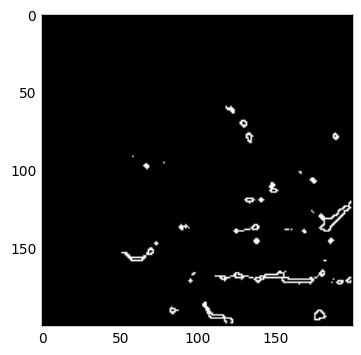

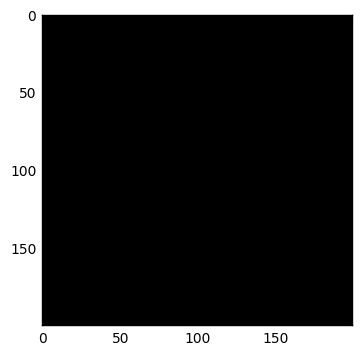

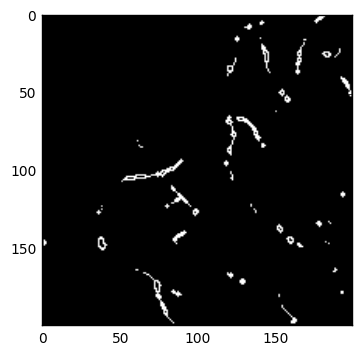

In [16]:
#image samples of VolumeLabels
image1 = new_VolumeLabels[2,:,:,50]
plt.imshow(image1,cmap='gray')
plt.show()
image2 = new_VolumeLabels[4,:,:,50]
plt.imshow(image2,cmap='gray')
plt.show()
image3 = new_VolumeLabels[6,:,:,50]
plt.imshow(image3,cmap='gray')
plt.show()

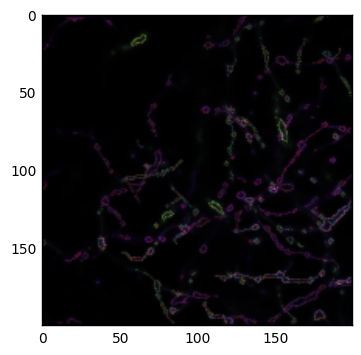

In [17]:
#image sample of overallRawVolume
image4 = overallRawVolume[:,:,50,:3]
plt.imshow(image4,cmap='gray')
plt.show()

In [4]:
def one_one_case_coor(label_3D_image):
    '''
        Input: label_3D_image -- 3D array of shape=(num_neuron_types,length,width),
                                 label array for one slice of raw volume. E.g., new_VolumeLabels[:,:,:,50]
        Output: one_one_coor -- list. Each entry is a 2d coordinate of [1,1] (meaning two adjacent 
                                neurons belong to the same type) case.
        The function finds out all coordinate of [1,1] case given a label array for one slice of raw volume.
    '''
    num_type, L, W = label_3D_image.shape
    one_one_coor = []
    for neuron_type in range(num_type):
        label_one_xcoor, label_one_ycoor = np.where( label_3D_image[neuron_type,:,:] == 1 )
        label_one_coor = zip(label_one_xcoor.tolist(), label_one_ycoor.tolist())
        for x,y in label_one_coor:
            if (y < W-1) and (label_3D_image[neuron_type, x, y] == label_3D_image[neuron_type, x, y+1]) \
            and ((x,y) not in one_one_coor):
                one_one_coor.append((x,y))
                assert(label_3D_image[neuron_type, x, y] == 1)
    
    return one_one_coor

In [31]:
one_one_coor = one_one_case_coor(new_VolumeLabels[:,:,:,50])
print(len(one_one_coor))

1823


In [5]:
def one_zero_case_coor(label_3D_image, one_one_coor):
    '''
        Inputs: label_3D_image -- 3D array of shape=(num_neuron_types,length,width),
                                  label array for one slice of raw volume. E.g., new_VolumeLabels[:,:,:,50]
                one_one_coor -- list. Each entry is a 2d coordinate of [1,1] (meaning two adjacent 
                                neurons belong to the same type) case.
        Output: one_zero_coor -- list. Each entry is a 2d coordinate of [1,0] (meaning two adjacent 
                                neurons belong to different type or the left voxel is a neuron while 
                                the right one is a background) case.
        This function finds out all coordinate of [1,0] case given a label array for one slice of raw volume.
    '''
    num_type, L, W = label_3D_image.shape
    one_zero_coor = []
    for neuron_type in range(num_type):
        label_one_xcoor, label_one_ycoor = np.where( label_3D_image[neuron_type,:,:] == 1 )
        label_one_coor = zip(label_one_xcoor.tolist(), label_one_ycoor.tolist())
        for x,y in label_one_coor:
            if (y < W-1) and (label_3D_image[neuron_type, x, y+1] == 0) \
            and ((x,y) not in one_zero_coor) and ((x,y) not in one_one_coor):
                one_zero_coor.append((x,y))
                assert(label_3D_image[neuron_type, x, y] == 1 and label_3D_image[neuron_type, x, y+1] == 0)
        
    return one_zero_coor

In [33]:
one_zero_coor = one_zero_case_coor(new_VolumeLabels[:,:,:,50], one_one_coor)
print(len(one_zero_coor))

1325


In [6]:
def zero_one_case_coor(label_3D_image, one_one_coor, one_zero_coor):
    '''
        Inputs: label_3D_image -- 3D array of shape=(num_neuron_types,length,width),
                                  label array for one slice of raw volume. E.g., new_VolumeLabels[:,:,:,50]
                one_one_coor -- list. Each entry is a 2d coordinate of [1,1] (meaning two adjacent 
                                neurons belong to the same type) case.
                one_zero_coor -- list. Each entry is a 2d coordinate of [1,0] (meaning two adjacent 
                                neurons belong to different type or the left voxel is a neuron while 
                                the right one is a background) case.                
        Output: zero_one_coor -- list. Each entry is a 2d coordinate of [0,1] (meaning two adjacent 
                                neurons belong to different type or the left voxel is a background while 
                                the right one is a neuron) case.
        This function finds out all coordinate of [0,1] case given a label array for one slice of raw volume.
    '''
    num_type, L, W = label_3D_image.shape
    zero_one_coor = []
    coor_union = one_one_coor + one_zero_coor
    for neuron_type in range(num_type):
        label_one_xcoor, label_one_ycoor = np.where( label_3D_image[neuron_type,:,:] == 1 )
        label_one_coor = zip(label_one_xcoor.tolist(), label_one_ycoor.tolist())
        for x,y in label_one_coor:
            if (y < W-1) and (y > 0) and (label_3D_image[neuron_type, x, y-1] == 0) \
                and ((x,y-1) not in coor_union) \
                and ((x,y-1) not in zero_one_coor):
                zero_one_coor.append((x,y-1))
                assert(label_3D_image[neuron_type, x, y]==1 and label_3D_image[neuron_type, x, y-1]==0)
        
    return zero_one_coor

In [35]:
zero_one_coor = zero_one_case_coor(new_VolumeLabels[:,:,:,50], one_one_coor, one_zero_coor)
print(len(zero_one_coor))

1280


In [7]:
def zero_zero_case_coor(label_3D_image, one_one_coor, one_zero_coor, zero_one_coor):
    '''
        Inputs: label_3D_image -- 3D array of shape=(num_neuron_types,length,width),
                                  label array for one slice of raw volume. E.g., new_VolumeLabels[:,:,:,50]
                one_one_coor -- list. Each entry is a 2d coordinate of [1,1] (meaning two adjacent 
                                neurons belong to the same type) case.
                one_zero_coor -- list. Each entry is a 2d coordinate of [1,0] (meaning two adjacent 
                                neurons belong to different type or the left voxel is a neuron while 
                                the right one is a background) case.
                zero_one_coor -- list. Each entry is a 2d coordinate of [0,1] (meaning two adjacent 
                                neurons belong to different type or the left voxel is a background while 
                                the right one is a neuron) case.
        Output: zero_zero_coor -- list. Each entry is a 2d coordinate of [0,0] (meaning two adjacent 
                                  neurons are both background) case.
        This function finds out all coordinate of [0,0] case given a label array for one slice of raw volume.
    '''
    num_type, L, W = label_3D_image.shape
    coor_union = one_one_coor + one_zero_coor + zero_one_coor
    all_coor = list(product(range(L), range(W-1)))
    zero_zero_case = [item for item in all_coor if item not in coor_union]
    
    return zero_zero_case

In [39]:
zero_zero_coor = zero_zero_case_coor(new_VolumeLabels[:,:,:,50], one_one_coor, one_zero_coor, zero_one_coor)
print(len(zero_zero_coor))

35372


In [8]:
def four_cases_coor(label_4D_image):
    '''
        Input: label_4D_image -- 4D array of shape=(num_neuron_types,length,width,height)
                                 label array for the whole raw volume. E.g., new_VolumeLabels.
        outputs: one_one -- list. Each entry is a 3d coordinate of a voxel which belongs to [1,1] case.
                one_zero -- list. Each entry is a 3d coordinate of a voxel which belongs to [1,0] case.
                zero_one -- list. Each entry is a 3d coordinate of a voxel which belongs to [0,1] case.
                zero_zero -- list. Each entry is a 3d coordinate of a voxel which belongs to [0,0] case.
        This function divides voxels of a volume into 4 cases (i.e., [1,1], [1,0], [0,1], [0,0])
        and stores the coordinates in the corresponding list.
    '''
    one_one = []
    one_zero = []
    zero_one = []
    zero_zero = []
    _, L, W, H = label_4D_image.shape
    for z in range(H):
        one_one_coor = one_one_case_coor(label_4D_image[:,:,:,z])
        num_one_one = len(one_one_coor)
        one_one += list(zip(one_one_coor, [z]*num_one_one))
        
        one_zero_coor = one_zero_case_coor(label_4D_image[:,:,:,z], one_one_coor)
        num_one_zero = len(one_zero_coor)
        one_zero += list(zip(one_zero_coor, [z]*num_one_zero))
        
        zero_one_coor = zero_one_case_coor(label_4D_image[:,:,:,z], one_one_coor, one_zero_coor)
        num_zero_one = len(zero_one_coor)
        zero_one += list(zip(zero_one_coor, [z]*num_zero_one))
        
        zero_zero_coor = zero_zero_case_coor(label_4D_image[:,:,:,z], one_one_coor, one_zero_coor, zero_one_coor)
        num_zero_zero = len(zero_zero_coor)
        zero_zero += list(zip(zero_zero_coor, [z]*num_zero_zero))
    
    return one_one, one_zero, zero_one, zero_zero

In [41]:
one_one, one_zero, zero_one, zero_zero = four_cases_coor(new_VolumeLabels)

In [42]:
print(len(one_one), len(one_zero), len(zero_one), len(zero_zero))

77000 63816 62409 3776775


In [9]:
def undersampling(coor_list, num_samples):
    '''
        Inputs: coor_list -- list. Each entry is a coordinate.
                num_samples -- integer. Denotes hom many samples user needs after undersampling.
        Output: new_coor_list -- list. Subset of coor_list.
        This function randomly selects num_samples samples from coor_list.
    '''
    num_all_datapoints = len(coor_list)
    samples_index = np.random.randint(0,num_all_datapoints,num_samples).tolist()
    new_coor_list = [coor_list[i] for i in samples_index]
    
    return new_coor_list

In [10]:
def balance_dataset(one_one, one_zero, zero_one, zero_zero):
    '''
        Inputs: one_one, one_zero, zero_one, zero_zero -- Each is a list consists of coordinates
                                                          belong to corresponding case.
        Outputs: one_one -- list. The same as input one_one.
                 balanced_one_zero -- list. Subset of one_zero which has around 1/3 number of samples of one_one.
                 balanced_zero_one -- list. Subset of zero_one which has aroud 1/3 number of samples of one_one.
                 balanced_zero_zero -- list. Subset of zero_zero which has around 1/3 number of samples of one_one.
        This function balances the 4 input datasets by undersampling the other three(one_zero, zero_one, zero_zero).
    '''
    num_one_one = len(one_one)
    num_one_zero_need = num_one_one // 3
    num_zero_one_need = num_one_zero_need
    num_zero_zero_need = num_one_one - num_one_zero_need*2
    balanced_one_zero = undersampling(one_zero, num_one_zero_need)
    balanced_zero_one = undersampling(zero_one, num_zero_one_need)
    balanced_zero_zero = undersampling(zero_zero, num_zero_zero_need)
    
    return one_one, balanced_one_zero, balanced_zero_one, balanced_zero_zero 

In [48]:
balanced_one_one, balanced_one_zero, balanced_zero_one, balanced_zero_zero = balance_dataset(one_one, one_zero, zero_one, zero_zero)

In [50]:
print(len(balanced_one_one), len(balanced_one_zero), len(balanced_zero_one), len(balanced_zero_zero))

77000 25666 25666 25668


In [11]:
def vectorize_y(num_datapoint, label):
    '''
        Inputs: num_datapoint -- integer. Denotes the number of dataponits.
                label -- 0 or 1. Represents the label of a datapoint.
        Output: y -- list. Each entry is a binary encoding.
        This function converts output label (i.e., 0 or 1) into a one-hot vector format.
        0 -> [1,0] and 1 -> [0,1].
    '''
    if label == 1:
        y = [[0,1]] * num_datapoint
    else:
        y = [[1,0]] * num_datapoint
        
    return y

In [12]:
def Y_generator(label_one_coor, label_zero_coor):
    '''
        Input: label_one_coor -- a list consists of coordinates belong to label one case.
               label_zero_coor -- a list consists of coordinates belong to label zero case.
        Output: array of shape = (len(label_one_coor)+len(label_zero_coor), 2)
        This function generate output array Y.
    '''
    Y=[]
    Y += vectorize_y(len(label_one_coor), 1)
    Y += vectorize_y(len(label_zero_coor), 0)
    Y = np.asarray(Y, dtype=np.float)
    
    return Y

In [82]:
label_one_coor = balanced_one_one
label_zero_coor = balanced_one_zero + balanced_zero_one + balanced_zero_zero
Y = Y_generator(label_one_coor, label_zero_coor)

In [13]:
def image_augmentation_each_layer(image_3D, extra_length, zero_padding=True):
    '''
        Inputs: image_3D -- 3d image of shape=(Length, Width, num_Channel), which is sliced from the 4d raw volume.
                extra_length -- integer. Denotes the additional length we need to add to the 'Length' and 'Width'
                                of the image_3D so that the patch size will be [2*extra_length+1, 2*extra_length+1, num_Channel].
                zero_padding -- Boolean (default is True). 'True' means the additional volume is all background (i.e. zero padding).
                                False means the additonal volume will be filled by other techniques.
                                For now, we use 'mirror' technique as default method. Other methods will be
                                added in furture versions.
        Output: new_image_3D -- 3d image of shape=(2*extra_length+Length, 2*extra_length+Width, num_Channel)
        This function use zero padding or 'mirror' padding to augment a 3d image image_3D.
    '''
    L, W, num_channel = image_3D.shape
    new_L = L + 2*extra_length
    new_W = W + 2*extra_length
    new_image_3D = np.zeros([new_L, new_W, num_channel])
    new_image_3D[extra_length:L+extra_length,extra_length:W+extra_length,:] = image_3D
    if zero_padding is False:
        #argument left side:
        new_image_3D[extra_length:L+extra_length,:extra_length,:] = np.fliplr(image_3D)[:,W-extra_length:,:]
        #argument right side:
        new_image_3D[extra_length:L+extra_length,extra_length+W:,:] = np.fliplr(image_3D)[:,:extra_length,:]
        #argument top side:
        new_image_3D[:extra_length,extra_length:W+extra_length,:] = np.flipud(image_3D)[L-extra_length:,:,:]
        #argument bottom side:
        new_image_3D[L+extra_length:,extra_length:W+extra_length,:] = np.flipud(image_3D)[:extra_length,:,:]
    
    return new_image_3D

In [100]:
augmented_image = image_augmentation_each_layer(overallRawVolume[:,:,50,:], 7, True)

In [14]:
def augmented_overallRawVolume(RawVolume, extra_length, zero_padding=True):
    '''
        Inputs: RawVolume -- 4d array of shape=(Length,Width,Height,num_Channel) represents the raw volume.
                extra_length -- integer. Denotes the additional length we need to add to the 'Length' and 'Width'
                                of the slice of the raw volume so that the patch size
                                will be [2*extra_length+1, 2*extra_length+1, num_Channel].
                zero_padding -- Boolean (default is True). 'True' means the additional volume is all background (i.e. zero padding).
                                False means the additonal volume will be filled by other techniques.
                                For now, we use 'mirror' technique as default method. Other methods will be
                                added in furture versions.
        Output: new_RawVolume -- 4d array of shape=(2*extra_length+Length, 2*extra_length+Width, Height, num_Channel)
        This function use zero padding or 'mirror' padding to augment each slice of the raw volume. 
    '''
    L, W, H, num_channel = RawVolume.shape
    new_RawVolume = np.zeros([L+2*extra_length, W+2*extra_length, H, num_channel])
    for layer in range(H):
        new_RawVolume[:,:,layer,:] = image_augmentation_each_layer(RawVolume[:,:,layer,:], extra_length, zero_padding)
    
    return new_RawVolume

In [58]:
new_overallRawVolume = augmented_overallRawVolume(overallRawVolume, 7)

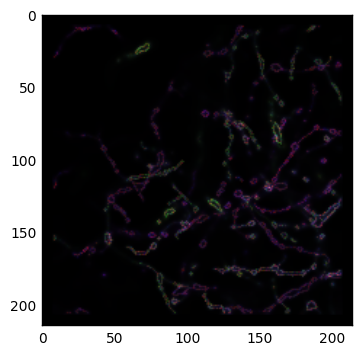

In [59]:
plt.imshow(new_overallRawVolume[:,:,50,:3],cmap='gray')
plt.show()

In [15]:
def X_generator(coor_list, new_RawVolume, extra_length):
    '''
        Inputs: coor_list -- list consists of 3d coordinates of the center voxel of the patch.
                new_RawVolume -- 4d array of shape=(2*extra_length+Length, 2*extra_length+Width, Height, num_Channel).
                extra_length -- integer. Determine how large is the patch size, since
                                patch size = [2*extra_length+1, 2*extra_length+1, num_Channel].
        Output: X -- 3d array. Denotes input dataponts.  
    '''
    X = []
    for ((i,j),k) in coor_list:
        new_i, new_j = (i + extra_length, j + extra_length)
        input_array = new_RawVolume[new_i-extra_length:new_i+1+extra_length,new_j-extra_length:new_j+1+extra_length,k,:]
        X.append(input_array)
    X = np.stack(X, axis=0)
    
    return X

In [120]:
coor_list = balanced_one_one + balanced_one_zero + balanced_zero_one + balanced_zero_zero
X = X_generator(coor_list,new_overallRawVolume, 7)

In [121]:
print(X.shape, Y.shape)

(154000, 15, 15, 4) (154000, 2)


In [16]:
def six_directions_volume_label(RawVolume, VolumeLabel):
    '''
        Inputs: RawVolume -- 4D image array of shape=(Length, Width, Height, num_Channel).
                VolumeLabel -- 4D label array of shape=(num_neuron_types, Length, Width, Height).
        Output: Volume_Label_dict -- dictionary of six (key, value) pair.
                                     'key' name is one of {'y-plus', 'y-minus', 'x-plus',
                                     'x-minus', 'z-plus', 'z-minus'} which denotes the six connections
                                     to which each voxel has the surrounding voxels. (reference: 3D coordinate system)
                                     'value' is a dictionary contains (key,value)=('volume',volume)
                                     and (key,value)=('label',volume_label)
                                              
        This function finds out the corresponding volume and label array of each direction 
        by rotating and interchange two axes of RawVolume and VolumeLabel.         
    '''
    Volume_Label_dict = {'y-plus':{}, 'y-minus':{}, 'x-plus':{}, 'x-minus':{}, 'z-plus':{}, 'z-minus':{}}
    # y-plus direction:
    Volume_Label_dict['y-plus']['volume'] = RawVolume
    Volume_Label_dict['y-plus']['volume_label'] = VolumeLabel
    
    # y-minus direction: rotate an array by 180 degree counterclockwise.
    Volume_Label_dict['y-minus']['volume'] = np.rot90(RawVolume, 2, (0,1))          
    Volume_Label_dict['y-minus']['volume_label'] = np.rot90(VolumeLabel, 2, (1,2))  
    
    #x-plus direction: rotate an array by 90 degree counterclockwise.
    Volume_Label_dict['x-plus']['volume'] = np.rot90(RawVolume, 1, (0,1))           
    Volume_Label_dict['x-plus']['volume_label'] = np.rot90(VolumeLabel, 1, (1,2))   
    
    #x-minus direction: rotate an array by 270 degree counterclockwise.
    Volume_Label_dict['x-minus']['volume'] = np.rot90(RawVolume, 3, (0,1))           
    Volume_Label_dict['x-minus']['volume_label'] = np.rot90(VolumeLabel, 3, (1,2))  
    
    #z-plus direction: interchange two axes of an array and rotate by 270 degree counterclockwise.
    Volume_Label_dict['z-plus']['volume'] = np.rot90(np.swapaxes(RawVolume,0,2), 3, (0,1)) 
    Volume_Label_dict['z-plus']['volume_label'] = np.rot90(np.swapaxes(VolumeLabel,1,3), 3, (1,2))
    
    #z-minus direction: interchange two axes of an array and rotate by 90 degree counterclockwise.
    Volume_Label_dict['z-minus']['volume'] = np.rot90(np.swapaxes(RawVolume,0,2), 1, (0,1)) 
    Volume_Label_dict['z-minus']['volume_label'] = np.rot90(np.swapaxes(VolumeLabel,1,3), 1, (1,2))
    
    return Volume_Label_dict

In [7]:
Volume_Label_dict = six_directions_volume_label(overallRawVolume, new_VolumeLabels)

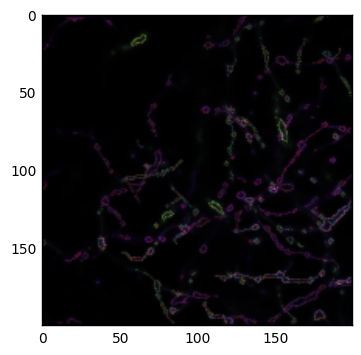

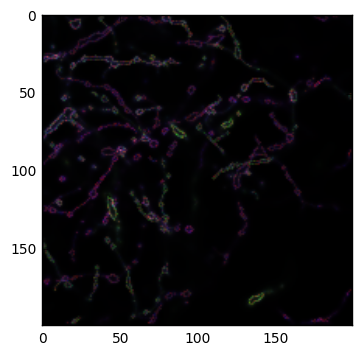

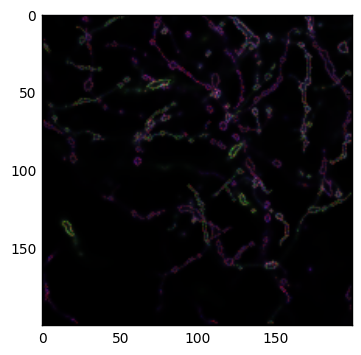

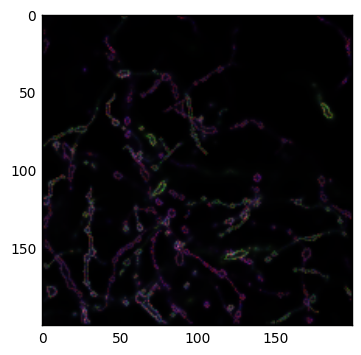

In [97]:
plt.imshow(Volume_Label_dict['y-plus']['volume'][:,:,50,:3],cmap='gray')
plt.show()
plt.imshow(Volume_Label_dict['y-minus']['volume'][:,:,50,:3],cmap='gray')
plt.show()
plt.imshow(Volume_Label_dict['x-plus']['volume'][:,:,50,:3],cmap='gray')
plt.show()
plt.imshow(Volume_Label_dict['x-minus']['volume'][:,:,50,:3],cmap='gray')
plt.show()

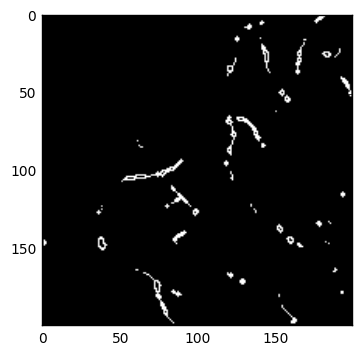

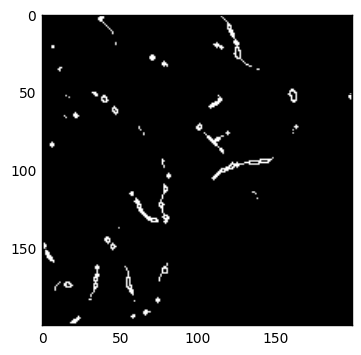

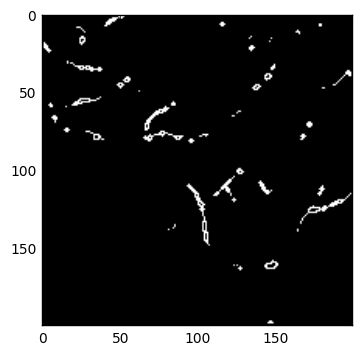

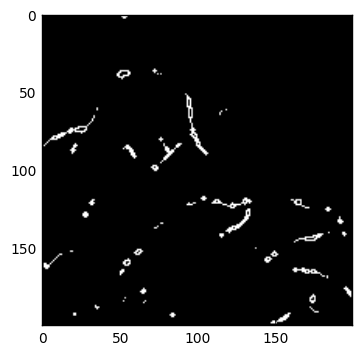

In [98]:
plt.imshow(Volume_Label_dict['y-plus']['volume_label'][6,:,:,50],cmap='gray')
plt.show()
plt.imshow(Volume_Label_dict['y-minus']['volume_label'][6,:,:,50],cmap='gray')
plt.show()
plt.imshow(Volume_Label_dict['x-plus']['volume_label'][6,:,:,50],cmap='gray')
plt.show()
plt.imshow(Volume_Label_dict['x-minus']['volume_label'][6,:,:,50,],cmap='gray')
plt.show()

In [17]:
def X_Y_generator_six_directions(Volume_Label_dict, extra_length):
    '''
        Input: Volume_Label_dict -- dictionary of six (key, value) pair.
                                    'key' name is one of {'y-plus', 'y-minus', 'x-plus',
                                    'x-minus', 'z-plus', 'z-minus'} which denotes the six connections
                                    to which each voxel has the surrounding voxels. (reference: 3D coordinate system)
                                    'value' is a dictionary contains (key,value)=('volume',volume)
                                    and (key,value)=('label',volume_label)
               extra_length -- integer. Determine how large is the patch size, since
                               patch size = [2*extra_length+1, 2*extra_length+1, num_Channel].
        Output: X -- input array of shape=(num_datapoints, 2*extra_length+1, 2*extra_length+1, num_Channel)
                Y -- output array of shape=(num_datapoints, 2)
        This function generates X (input dataset) and Y (output dataset). The size of the input datapoint
        is determined by 'extra_length'.
    '''
    Y=[]
    X=[]
    for direction in Volume_Label_dict.keys():
        Volume = Volume_Label_dict[direction]['volume']
        Volume_Label = Volume_Label_dict[direction]['volume_label']
        one_one, one_zero, zero_one, zero_zero = four_cases_coor(Volume_Label)
        balanced_one_one, balanced_one_zero, balanced_zero_one, balanced_zero_zero = balance_dataset(one_one, one_zero, zero_one, zero_zero)
        label_one_coor = balanced_one_one
        label_zero_coor = balanced_one_zero + balanced_zero_one + balanced_zero_zero
        Y.append(Y_generator(label_one_coor, label_zero_coor))
        new_overallRawVolume = augmented_overallRawVolume(Volume, extra_length)
        coor_list = label_one_coor + label_zero_coor
        X.append(X_generator(coor_list, new_overallRawVolume, 7))
    
    Y = np.concatenate(tuple(Y),axis=0)
    X = np.concatenate(tuple(X),axis=0)
    return X,Y

In [127]:
X,Y = X_Y_generator_six_directions(Volume_Label_dict, 7)

In [18]:
def train_test_division(X_data, Y_data, test_ratio):
    '''
        Input: X_data -- input array of shape=(num_patch, patch_length, patch_width, num_channel).
               Y_data -- output array of shape=(num_patch, 2).
               test_ratio -- float/double number, range=(0,1), represents the ratio between num_test_datapoints and num_total_datapoints. 
        Output: X_train -- training input array.
                Y_train -- training output array.
                X_test -- test input array.
                Y_test -- test output array.
        This function divides raw X(input features),Y(output labels) into training and test X, Y. 
    '''
    num_datapoints = X_data.shape[0]
    test_datapoints_index = np.random.randint(0,num_datapoints,int(num_datapoints*test_ratio)).tolist()
    train_datapoints_index = [index for index in range(num_datapoints) if index not in test_datapoints_index]
    X_test = X_data[test_datapoints_index,:,:,:]
    Y_test = Y_data[test_datapoints_index,:]
    X_train = X_data[train_datapoints_index,:,:,:]
    Y_train = Y_data[train_datapoints_index,:]
    
    return X_train, Y_train, X_test, Y_test

In [129]:
x_train, y_train, x_test, y_test = train_test_division(X, Y, 0.2)

In [134]:
f = open("training_validation_dataset.bin","wb")
np.save(f,x_train)
np.save(f,y_train)
np.save(f,x_test)
np.save(f,y_test)
f.close()

In [19]:
def get_confusion_matrix_one_hot(model_predictions, true_labels):
    '''
        Inputs: model_predictions -- 2D array of shape=(num_datapoints, num_classes) denotes
                                     model predictions.
                true_labels -- 2D array of shape=(num_datapoints, num_classes)
        Output: confusion_matrix -- 2D array of shape=(num_classes, num_classes)
        This function generates the confusion matrix.
    '''
    assert model_predictions.shape == true_labels.shape
    num_classes = true_labels.shape[1]
    confusion_matrix = np.zeros((num_classes, num_classes), dtype=np.int32)
    predictions = np.argmax(model_predictions,axis=1)
    assert len(predictions)==true_labels.shape[0]

    for actual_class in range(num_classes):
        idx_examples_this_class = true_labels[:,actual_class]==1.0
        prediction_for_this_class = predictions[idx_examples_this_class]
        for predicted_class in range(num_classes):
            count = np.sum(prediction_for_this_class==predicted_class)
            confusion_matrix[actual_class, predicted_class] = count
    assert np.sum(confusion_matrix)==len(true_labels)
    assert np.sum(confusion_matrix)==np.sum(true_labels)
    
    return confusion_matrix

In [20]:
from __future__ import print_function
import keras
from keras.datasets import cifar10
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation, Flatten
from keras.layers import Conv2D, MaxPooling2D
from keras.optimizers import RMSprop

Using TensorFlow backend.


In [137]:
batch_size = 1000
num_classes = 2
epochs = 10

In [21]:
def count_two_class(Y_data):
    '''
        Input: Y_data -- output one-hot array with shape=(num_datapoints, 2)
        Output: None
        This function prints count number of each label in Y_data
    '''
    num_datapoints = Y_data.shape[0]
    num_label_0, num_label_1 = (0,0)
    for i in range(num_datapoints):
        if Y_data[i,0]==1.0:
            num_label_0 += 1
        else:
            num_label_1 += 1
    print('label 0: {0}, {1}; label 1: {2}, {3}.'.format(num_label_0, \
         float(num_label_0)/float(num_datapoints), num_label_1, float(num_label_1)/float(num_datapoints)))

In [139]:
count_two_class(y_train)
count_two_class(y_test)

label 0: 389263, 0.49997944918683; label 1: 389295, 0.50002055081317.
label 0: 95137, 0.50025765606596; label 1: 95039, 0.49974234393404005.


In [140]:
model = Sequential()

model.add(Conv2D(8, (3, 3), padding='same',input_shape=x_train.shape[1:]))
model.add(Activation('relu'))
print(model.output_shape)
model.add(Conv2D(16, (4, 4),padding='valid'))
model.add(Activation('relu'))
print(model.output_shape)
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.2))
print(model.output_shape)
model.add(Conv2D(32, (2, 2), padding='same'))
model.add(Activation('relu'))
print(model.output_shape)
model.add(Conv2D(32, (3, 3), padding='valid'))
model.add(Activation('relu'))
print(model.output_shape)
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.2))
print(model.output_shape)
model.add(Flatten())
print(model.output_shape)
model.add(Dense(128))
model.add(Activation('relu'))
model.add(Dropout(0.5))
model.add(Dense(num_classes))
model.add(Activation('softmax'))
print(model.output_shape)
model.summary()

(None, 15, 15, 8)
(None, 12, 12, 16)
(None, 6, 6, 16)
(None, 6, 6, 32)
(None, 4, 4, 32)
(None, 2, 2, 32)
(None, 128)
(None, 2)
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 15, 15, 8)         296       
_________________________________________________________________
activation_1 (Activation)    (None, 15, 15, 8)         0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 12, 12, 16)        2064      
_________________________________________________________________
activation_2 (Activation)    (None, 12, 12, 16)        0         
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 6, 6, 16)          0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 6, 6, 16)          0         
_______________

In [141]:
# initiate RMSprop optimizer
opt = keras.optimizers.rmsprop(lr=0.0001, decay=1e-6)
# Let's train the model using RMSprop
model.compile(loss='categorical_crossentropy',
              optimizer=RMSprop(),
              metrics=['accuracy'])
history = model.fit(x_train, y_train,
              batch_size=batch_size,
              epochs=epochs,
              validation_data=(x_test, y_test),
              shuffle=True)
score = model.evaluate(x_test, y_test, verbose=1)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

Train on 778558 samples, validate on 190176 samples
Epoch 1/10
778558/778558 [==============================] - 336s - loss: 0.3520 - acc: 0.8396 - val_loss: 0.1894 - val_acc: 0.9250
Epoch 2/10
778558/778558 [==============================] - 345s - loss: 0.1646 - acc: 0.9377 - val_loss: 0.0886 - val_acc: 0.9690
Epoch 3/10
778558/778558 [==============================] - 361s - loss: 0.1033 - acc: 0.9640 - val_loss: 0.0599 - val_acc: 0.9812
Epoch 4/10
778558/778558 [==============================] - 350s - loss: 0.0807 - acc: 0.9735 - val_loss: 0.0538 - val_acc: 0.9841
Epoch 5/10
778558/778558 [==============================] - 331s - loss: 0.0704 - acc: 0.9779 - val_loss: 0.0525 - val_acc: 0.9844
Epoch 6/10
778558/778558 [==============================] - 340s - loss: 0.0640 - acc: 0.9805 - val_loss: 0.0454 - val_acc: 0.9869
Epoch 7/10
778558/778558 [==============================] - 340s - loss: 0.0599 - acc: 0.9820 - val_loss: 0.0441 - val_acc: 0.9876
Epoch 8/10
778558/778558 [=====

In [142]:
model_predictions = model.predict(x_test, batch_size=100, verbose=1)
get_confusion_matrix_one_hot(model_predictions, y_test)

190000/190176 [============================>.] - ETA: 0s

array([[93833,  1304],
       [  844, 94195]], dtype=int32)

In [22]:
overallRawVolume = sio.loadmat('../Sample_Datasets/Test/overallRawVolume.mat')['overallRawVolume'].astype(np.float) #shape=(200, 200, 100, 4), value range=(0,1)
volumeLabels = sio.loadmat('../Sample_Datasets/Test/volumeLabels.mat')['volumeLabels']#shape=(1, 9), each entry is an array with shape=(200, 200, 100)

In [23]:
new_VolumeLabels = process_volumeLabels(volumeLabels) #shape=(9,200,200,100)

In [146]:
Volume_Label_dict = six_directions_volume_label(overallRawVolume, new_VolumeLabels)
X,Y = X_Y_generator_six_directions(Volume_Label_dict, 7)

In [147]:
score = model.evaluate(X, Y, verbose=1)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

850172/850172 [==============================] - 164s   
Test loss: 0.108699364571
Test accuracy: 0.965692824511


In [148]:
model_predictions = model.predict(X, batch_size=1000, verbose=1)
get_confusion_matrix_one_hot(model_predictions, Y)

850000/850172 [============================>.] - ETA: 0s

array([[409570,  15516],
       [ 13651, 411435]], dtype=int32)

In [143]:
model.save('neuron_classifier_v1.h5')

In [24]:
from keras.models import load_model
model = load_model('neuron_classifier_v1.h5')
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 15, 15, 8)         296       
_________________________________________________________________
activation_1 (Activation)    (None, 15, 15, 8)         0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 12, 12, 16)        2064      
_________________________________________________________________
activation_2 (Activation)    (None, 12, 12, 16)        0         
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 6, 6, 16)          0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 6, 6, 16)          0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 6, 6, 32)          2080      
__________

In [25]:
Volume_Label_dict = six_directions_volume_label(overallRawVolume, new_VolumeLabels)

In [26]:
def predictions_one_direction(RawVolume_One_Direction, trained_model, extra_length):
    '''
        Input: RawVolume_One_Direction -- 4D array of shape=(Length,Width,Height,Num_Channel),
                                          represents RawVolume when we look at it from one direction.
               trained_model -- a trained CNNs model using Keras.
               extra_length -- integer. Determine how large is the patch size, since
                               patch size = [2*extra_length+1, 2*extra_length+1, num_Channel].
        Output: predictions -- 3D array of shape=(Length,Width-1,Height), Binary predictions of the volume.
        This function find alll predictions of the Volume in one direction.
    '''
    L,W,H,Num_Channel = RawVolume_One_Direction.shape
    predictions = np.empty([L,W-1,H],dtype=np.int)
    argumented_RawVolume = augmented_overallRawVolume(RawVolume_One_Direction, extra_length)
    for z in range(H):
        start = time.time()
        inputs = []
        for x in range(L):
            for y in range(W-1):
                new_x, new_y = (x + extra_length, y + extra_length)
                inputs.append(argumented_RawVolume[new_x-extra_length:new_x+1+extra_length,new_y-extra_length:new_y+1+extra_length,z,:])
        inputs = np.stack(inputs, axis=0)        
        prediction = trained_model.predict_classes(inputs, batch_size=W-1, verbose=0)
        predictions[:,:,z] = prediction.reshape((L,W-1),order='C')
        print('Layer {0} is predicted: using {1} s '.format(z, time.time() - start))
        
    return predictions

In [27]:
def predictions_all_six_directions(Volume_Label_dict, trained_model, extra_length):
    '''
        Input: Volume_Label_dict -- dictionary of six (key, value) pair.
                                    'key' name is one of {'y-plus', 'y-minus', 'x-plus',
                                    'x-minus', 'z-plus', 'z-minus'} which denotes the six connections
                                    to which each voxel has the surrounding voxels. (reference: 3D coordinate system)
                                    'value' is a dictionary contains (key,value)=('volume',volume)
                                    and (key,value)=('label',volume_label)
               trained_model -- a trained CNNs model using Keras.
               extra_length -- integer. Determine how large is the patch size, since
                               patch size = [2*extra_length+1, 2*extra_length+1, num_Channel].
        Output: predictions_dict -- dictionary of six (key, value) pair.
                                     'key' name is one of {'y-plus', 'y-minus', 'x-plus',
                                     'x-minus', 'z-plus', 'z-minus'} which denotes the six connections
                                     to which each voxel has the surrounding voxels. (reference: 3D coordinate system)
                                     'value' is the predictions of the volume in the 'key' direction.
    '''
    predictions_dict={}
    for direction in Volume_Label_dict.keys():
        start = time.time()
        RawVolume_One_Direction = Volume_Label_dict[direction]['volume']
        predictions = predictions_one_direction(RawVolume_One_Direction, trained_model, extra_length)
        predictions_dict[direction] = predictions
        print('Direction {0} is predicted: using {1} s '.format(direction, time.time() - start))
        
    return predictions_dict

In [28]:
predictions_dict = predictions_all_six_directions(Volume_Label_dict, model, 7)

Layer 0 is predicted: using 4.502317190170288 s 
Layer 1 is predicted: using 4.486385107040405 s 
Layer 2 is predicted: using 5.614152908325195 s 
Layer 3 is predicted: using 5.558851003646851 s 
Layer 4 is predicted: using 5.341439962387085 s 
Layer 5 is predicted: using 6.320523977279663 s 
Layer 6 is predicted: using 5.378077983856201 s 
Layer 7 is predicted: using 4.846195936203003 s 
Layer 8 is predicted: using 4.753434896469116 s 
Layer 9 is predicted: using 5.094030857086182 s 
Layer 10 is predicted: using 4.949375152587891 s 
Layer 11 is predicted: using 4.815388917922974 s 
Layer 12 is predicted: using 4.687113046646118 s 
Layer 13 is predicted: using 4.7244298458099365 s 
Layer 14 is predicted: using 4.7050299644470215 s 
Layer 15 is predicted: using 4.723405838012695 s 
Layer 16 is predicted: using 4.694936990737915 s 
Layer 17 is predicted: using 4.788025140762329 s 
Layer 18 is predicted: using 4.715137958526611 s 
Layer 19 is predicted: using 4.756882190704346 s 
Layer 20

In [29]:
predictions_dict = pickle.load( open( "predictions.pickle", "rb" ) )

In [30]:
rotated_predictions_dict={}
#Predictions of 'y-minus', 'x-plus' and 'x-minus' should be rotated back to the original direction.
rotated_predictions_dict['y-plus'] = predictions_dict['y-plus']
# y-minus direction: rotate an array by 180 degree counterclockwise.
rotated_predictions_dict['y-minus'] = np.rot90(predictions_dict['y-minus'], 2, (0,1))

#x-plus direction: rotate an array by 270 degree counterclockwise.
rotated_predictions_dict['x-plus'] = np.rot90(predictions_dict['x-plus'], 3, (0,1))

#x-minus direction: rotate an array by 90 degree counterclockwise.
rotated_predictions_dict['x-minus'] = np.rot90(predictions_dict['x-minus'], 1, (0,1))

#z-plus direction: interchange two axes of an array and rotate by 90 degree counterclockwise.
rotated_predictions_dict['z-plus'] = np.rot90(predictions_dict['z-plus'], 1, (0,1))

#z-minus direction: interchange two axes of an array and rotate by 270 degree counterclockwise.
rotated_predictions_dict['z-minus'] = np.rot90(predictions_dict['z-minus'], 3, (0,1)) 

In [31]:
print(rotated_predictions_dict['y-plus'].shape,
rotated_predictions_dict['y-minus'].shape,
rotated_predictions_dict['x-plus'].shape,
rotated_predictions_dict['x-minus'].shape,
rotated_predictions_dict['z-plus'].shape,
rotated_predictions_dict['z-minus'].shape)

(200, 199, 100) (200, 199, 100) (199, 200, 100) (199, 200, 100) (99, 200, 200) (99, 200, 200)


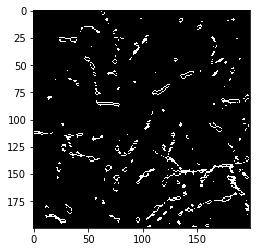

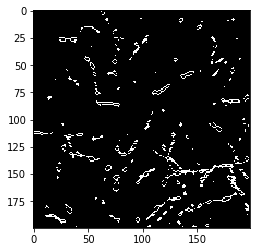

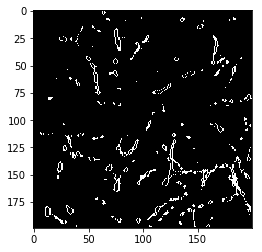

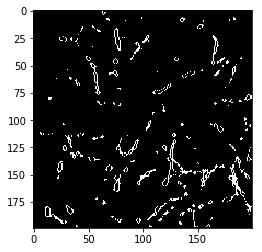

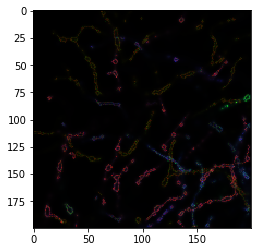

In [32]:
plt.imshow(rotated_predictions_dict['y-plus'][:,:,50],cmap='gray')
plt.show()
plt.imshow(rotated_predictions_dict['y-minus'][:,:,50],cmap='gray')
plt.show()
plt.imshow(rotated_predictions_dict['x-plus'][:,:,50],cmap='gray')
plt.show()
plt.imshow(rotated_predictions_dict['x-minus'][:,:,50],cmap='gray')
plt.show()
plt.imshow(Volume_Label_dict['y-plus']['volume'][:,:,50,:3],cmap='gray')
plt.show()

In [33]:
def current_voxel_label_6direction(rotated_predictions_dict, x_coor, y_coor, z_coor, x_lim, y_lim, z_lim):
    '''
        Inputs: rotated_predictions_dict -- dictionary that contains four directions' predictions
                                            ('key',value)=(direction, predictions array associated with the direction)
                                            'key'=['y-plus', 'y-minus', 'x-plus', 'x-minus', 'z-plus', 'z-minus']
                x_coor, y_coor, z_coor -- three integers that indicate the 3D coordinate of the current voxel.
                x_lim, y_lim, z_lim -- three integers that represent the length, width and height of the volume.
        Outputs: label -- 0/1. 0 means the current voxel is a background (i.e. not a neuron)
                          1 means the current voexl is a neuron.
    '''
    if x_coor>=1 and x_coor <= x_lim-2 and y_coor>=1 and y_coor<=y_lim-2:
        if (rotated_predictions_dict['y-plus'][x_coor, y_coor] +\
            rotated_predictions_dict['y-minus'][x_coor, y_coor-1] +\
            rotated_predictions_dict['x-plus'][x_coor, y_coor] +\
            rotated_predictions_dict['x-minus'][x_coor-1, y_coor]) == 0:
            label = 0
        else:
            label = 1
            
    elif x_coor==0 and y_coor>=1 and y_coor<=y_lim-2:
        if (rotated_predictions_dict['y-plus'][x_coor, y_coor] +\
            rotated_predictions_dict['y-minus'][x_coor, y_coor-1] +\
            rotated_predictions_dict['x-plus'][x_coor, y_coor]) == 0:
            label = 0
        else:
            label = 1
            
    elif x_coor==x_lim-1 and y_coor>=1 and y_coor<=y_lim-2:
        if (rotated_predictions_dict['y-plus'][x_coor, y_coor] +\
            rotated_predictions_dict['y-minus'][x_coor, y_coor-1] +\
            rotated_predictions_dict['x-minus'][x_coor-1, y_coor]) == 0:
            label = 0
        else:
            label = 1
            
    elif x_coor>=1 and x_coor <= x_lim-2 and y_coor==0:
        if (rotated_predictions_dict['y-plus'][x_coor, y_coor] +\
            rotated_predictions_dict['x-plus'][x_coor, y_coor] +\
            rotated_predictions_dict['x-minus'][x_coor-1, y_coor]) == 0:
            label = 0
        else:
            label = 1
    
    elif x_coor>=1 and x_coor <= x_lim-2 and y_coor==y_lim-1:
        if (rotated_predictions_dict['y-minus'][x_coor, y_coor-1] +\
            rotated_predictions_dict['x-plus'][x_coor, y_coor] +\
            rotated_predictions_dict['x-minus'][x_coor-1, y_coor]) == 0:
            label = 0
        else:
            label = 1
            
    elif x_coor==0 and y_coor==0:
        if (rotated_predictions_dict['y-plus'][x_coor, y_coor] +\
            rotated_predictions_dict['x-plus'][x_coor, y_coor]) == 0:
            label = 0
        else:
            label = 1
            
    elif x_coor==0 and y_coor==y_lim-1:
        if (rotated_predictions_dict['y-minus'][x_coor, y_coor-1] +\
            rotated_predictions_dict['x-plus'][x_coor, y_coor]) == 0:
            label = 0
        else:
            label = 1
            
    elif x_coor==x_lim-1 and y_coor==0:
        if (rotated_predictions_dict['y-plus'][x_coor, y_coor] +\
            rotated_predictions_dict['x-minus'][x_coor-1, y_coor]) == 0:
            label = 0
        else:
            label = 1
            
    elif x_coor==x_lim-1 and y_coor==y_lim-1:
        if (rotated_predictions_dict['y-minus'][x_coor, y_coor-1] +\
            rotated_predictions_dict['x-minus'][x_coor-1, y_coor]) == 0:
            label = 0
        else:
            label = 1
    
    if label == 0:
        if z_coor>=1 and z_coor<=z_lim-2:
            if (rotated_predictions_dict['z-plus'][z_coor-1,x_coor,y_coor] +\
                rotated_predictions_dict['z-minus'][z_coor,x_coor,y_coor])==0:
                label = 0
            else:
                label = 1
        elif z_coor==1:
            if (rotated_predictions_dict['z-minus'][z_coor,x_coor,y_coor])==0:
                label = 0
            else:
                label = 1
        elif z_coor==z_lim-1:
            if (rotated_predictions_dict['z-plus'][z_coor-1,x_coor,y_coor])==0:
                label = 0
            else:
                label = 1
    
    return label

In [34]:
def current_voxel_label_4direction(rotated_predictions_dict, x_coor, y_coor, x_lim, y_lim):
    '''
        Inputs: rotated_predictions_dict -- dictionary that contains four directions' predictions
                                            ('key',value)=(direction, one layer predictions array
                                            associated with the direction)
                                            'key'=['y-plus', 'y-minus', 'x-plus', 'x-minus']
                x_coor, y_coor -- two integers that indicate the 2D coordinate of the current voxel.
                x_lim, y_lim -- two integers that represent the length and width of the volume.
        Outputs: label -- 0/1. 0 means the current voxel is a background (i.e. not a neuron)
                          1 means the current voexl is a neuron.
    '''
    if x_coor>=1 and x_coor <= x_lim-2 and y_coor>=1 and y_coor<=y_lim-2:
        if (rotated_predictions_dict['y-plus'][x_coor, y_coor] +\
            rotated_predictions_dict['y-minus'][x_coor, y_coor-1] +\
            rotated_predictions_dict['x-plus'][x_coor, y_coor] +\
            rotated_predictions_dict['x-minus'][x_coor-1, y_coor]) == 0:
            label = 0
        else:
            label = 1
            
    elif x_coor==0 and y_coor>=1 and y_coor<=y_lim-2:
        if (rotated_predictions_dict['y-plus'][x_coor, y_coor] +\
            rotated_predictions_dict['y-minus'][x_coor, y_coor-1] +\
            rotated_predictions_dict['x-plus'][x_coor, y_coor]) == 0:
            label = 0
        else:
            label = 1
            
    elif x_coor==x_lim-1 and y_coor>=1 and y_coor<=y_lim-2:
        if (rotated_predictions_dict['y-plus'][x_coor, y_coor] +\
            rotated_predictions_dict['y-minus'][x_coor, y_coor-1] +\
            rotated_predictions_dict['x-minus'][x_coor-1, y_coor]) == 0:
            label = 0
        else:
            label = 1
            
    elif x_coor>=1 and x_coor <= x_lim-2 and y_coor==0:
        if (rotated_predictions_dict['y-plus'][x_coor, y_coor] +\
            rotated_predictions_dict['x-plus'][x_coor, y_coor] +\
            rotated_predictions_dict['x-minus'][x_coor-1, y_coor]) == 0:
            label = 0
        else:
            label = 1
    
    elif x_coor>=1 and x_coor <= x_lim-2 and y_coor==y_lim-1:
        if (rotated_predictions_dict['y-minus'][x_coor, y_coor-1] +\
            rotated_predictions_dict['x-plus'][x_coor, y_coor] +\
            rotated_predictions_dict['x-minus'][x_coor-1, y_coor]) == 0:
            label = 0
        else:
            label = 1
            
    elif x_coor==0 and y_coor==0:
        if (rotated_predictions_dict['y-plus'][x_coor, y_coor] +\
            rotated_predictions_dict['x-plus'][x_coor, y_coor]) == 0:
            label = 0
        else:
            label = 1
            
    elif x_coor==0 and y_coor==y_lim-1:
        if (rotated_predictions_dict['y-minus'][x_coor, y_coor-1] +\
            rotated_predictions_dict['x-plus'][x_coor, y_coor]) == 0:
            label = 0
        else:
            label = 1
            
    elif x_coor==x_lim-1 and y_coor==0:
        if (rotated_predictions_dict['y-plus'][x_coor, y_coor] +\
            rotated_predictions_dict['x-minus'][x_coor-1, y_coor]) == 0:
            label = 0
        else:
            label = 1
            
    elif x_coor==x_lim-1 and y_coor==y_lim-1:
        if (rotated_predictions_dict['y-minus'][x_coor, y_coor-1] +\
            rotated_predictions_dict['x-minus'][x_coor-1, y_coor]) == 0:
            label = 0
        else:
            label = 1
    
    return label

In [35]:
def label_image_construction(rotated_predictions_dict, Length, Width, Height):
    '''
        Inputs: rotated_predictions_dict -- dictionary that contains six directions' predictions
                                            ('key',value)=(direction, predictions array
                                            associated with the direction)
                                            'key'=['y-plus', 'y-minus', 'x-plus', 'x-minus','z-plus','z-minus']
                Length, Width, Height -- three integers that represent the length, width and height of the volume.
        Outputs: reconstruction -- 3D 0/1 label array of shape=(Length, Width, Height). Indicates that a voxel
                                   is a neuron or a background.
    '''
    reconstruction = np.zeros((Length, Width, Height), dtype=np.int)
    for z in range(Height):
        '''
        rotated_predictions_dict_6directions = {'y-plus':rotated_predictions_dict['y-plus'][:,:,z],
                                       'y-minus':rotated_predictions_dict['y-minus'][:,:,z],
                                       'x-plus':rotated_predictions_dict['x-plus'][:,:,z],
                                       'x-minus':rotated_predictions_dict['x-minus'][:,:,z],
                                       'z-plus':rotated_predictions_dict['z-plus'],
                                       'z-minus':rotated_predictions_dict['z-minus']}
        '''
        rotated_predictions_dict_4directions = {'y-plus':rotated_predictions_dict['y-plus'][:,:,z],
                                       'y-minus':rotated_predictions_dict['y-minus'][:,:,z],
                                       'x-plus':rotated_predictions_dict['x-plus'][:,:,z],
                                       'x-minus':rotated_predictions_dict['x-minus'][:,:,z]}
        
        for x in range(Length):
            for y in range(Width):
                #reconstruction[x,y,z] = current_voxel_label_6direction(rotated_predictions_dict_6directions, x, y, z, Length, Width, Height)
                reconstruction[x,y,z] = current_voxel_label_4direction(rotated_predictions_dict_4directions, x, y, Length, Width)
    
    return reconstruction

In [36]:
reconstruction = label_image_construction(rotated_predictions_dict, 200, 200, 100)

In [37]:
VolumeLabels_47 = new_VolumeLabels[:,:,:,47]
labels_sum_47 = np.sum(VolumeLabels_47,axis=0)
ground_truth_47 = (labels_sum_47>0).astype(np.int)
misclassified_locations_47 = (reconstruction[:,:,47]!=ground_truth_47).astype(np.int)
print('reconstruction accuracy of the 47th layer is : {0}'.format(np.sum((reconstruction[:,:,47]==ground_truth_47).astype(np.int))/(200**2.0)))

reconstruction accuracy of the 47th layer is : 0.992825


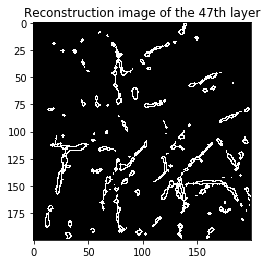

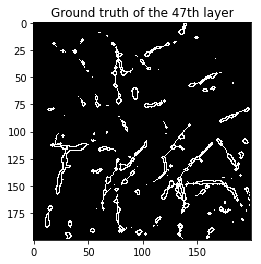

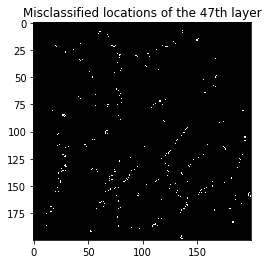

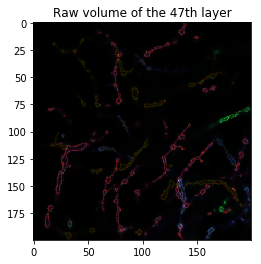

In [38]:
plt.imshow(reconstruction[:,:,47],cmap='gray')
plt.title('Reconstruction image of the 47th layer')
plt.show()
plt.imshow(ground_truth_47,cmap='gray')
plt.title('Ground truth of the 47th layer')
plt.show()
plt.imshow(misclassified_locations_47,cmap='gray')
plt.title('Misclassified locations of the 47th layer')
plt.show()
plt.imshow(Volume_Label_dict['y-plus']['volume'][:,:,47,:3],cmap='gray')
plt.title('Raw volume of the 47th layer')
plt.show()

In [39]:
VolumeLabels_57 = new_VolumeLabels[:,:,:,57]
labels_sum_57 = np.sum(VolumeLabels_57,axis=0)
ground_truth_57 = (labels_sum_57>0).astype(np.int)
misclassified_locations_57 = (reconstruction[:,:,57]!=ground_truth_57).astype(np.int)
print('reconstruction accuracy of the 57th layer is : {0}'.format(np.sum((reconstruction[:,:,57]==ground_truth_57).astype(np.int))/(200**2.0)))

reconstruction accuracy of the 57th layer is : 0.994075


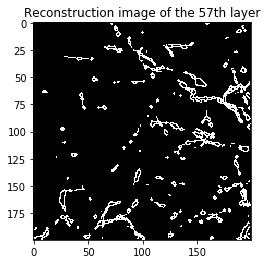

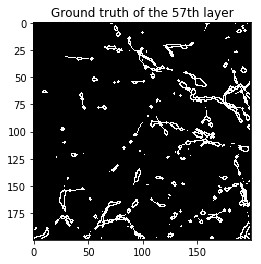

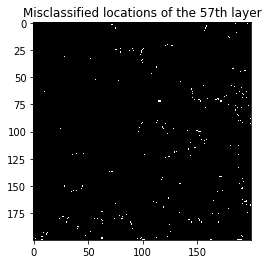

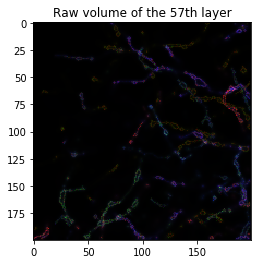

In [40]:
plt.imshow(reconstruction[:,:,57],cmap='gray')
plt.title('Reconstruction image of the 57th layer')
plt.show()
plt.imshow(ground_truth_57,cmap='gray')
plt.title('Ground truth of the 57th layer')
plt.show()
plt.imshow(misclassified_locations_57,cmap='gray')
plt.title('Misclassified locations of the 57th layer')
plt.show()
plt.imshow(Volume_Label_dict['y-plus']['volume'][:,:,57,:3],cmap='gray')
plt.title('Raw volume of the 57th layer')
plt.show()

In [41]:
def reconstruction_accuracy(reconstruction, new_VolumeLabels):
    '''
        Inputs:
    '''
    L,W,H = reconstruction.shape
    Total_correct_count = 0
    for z in range(H):
        VolumeLabels_z = new_VolumeLabels[:,:,:,z]
        labels_sum_z = np.sum(VolumeLabels_z, axis=0)
        ground_truth_z = (labels_sum_z>0).astype(np.int)
        local_correct_count = np.sum((reconstruction[:,:,z]==ground_truth_z).astype(np.int))
        print('Layer {0} accuracy is: {1}'.format(z, local_correct_count/(200**2.0)))
        Total_correct_count += local_correct_count
    print('Total accuracy is: {0}'.format(Total_correct_count/float(L*W*H)))

In [42]:
reconstruction_accuracy(reconstruction, new_VolumeLabels)

Layer 0 accuracy is: 0.998375
Layer 1 accuracy is: 0.99965
Layer 2 accuracy is: 0.9995
Layer 3 accuracy is: 0.9996
Layer 4 accuracy is: 0.999425
Layer 5 accuracy is: 0.999325
Layer 6 accuracy is: 0.999575
Layer 7 accuracy is: 0.99945
Layer 8 accuracy is: 0.999275
Layer 9 accuracy is: 0.999675
Layer 10 accuracy is: 0.99965
Layer 11 accuracy is: 0.999525
Layer 12 accuracy is: 0.99965
Layer 13 accuracy is: 0.999575
Layer 14 accuracy is: 0.999625
Layer 15 accuracy is: 0.9994
Layer 16 accuracy is: 0.999475
Layer 17 accuracy is: 0.999175
Layer 18 accuracy is: 0.999025
Layer 19 accuracy is: 0.999125
Layer 20 accuracy is: 0.99875
Layer 21 accuracy is: 0.9984
Layer 22 accuracy is: 0.998325
Layer 23 accuracy is: 0.999
Layer 24 accuracy is: 0.99865
Layer 25 accuracy is: 0.99865
Layer 26 accuracy is: 0.99855
Layer 27 accuracy is: 0.998425
Layer 28 accuracy is: 0.998375
Layer 29 accuracy is: 0.998425
Layer 30 accuracy is: 0.99815
Layer 31 accuracy is: 0.998225
Layer 32 accuracy is: 0.998525
Layer 3

In [64]:
def neuron_path_one_layer(rotated_predictions_one_layer, reconstruction_one_layer):
    '''
    '''
    Length,Width = reconstruction_one_layer.shape
    xs,ys = np.where(reconstruction_one_layer==1)
    all_neurons_locations = list(zip(xs.tolist(), ys.tolist()))
    neurons_coor = list(zip(xs.tolist(), ys.tolist()))
    neurons_coor_length = len(neurons_coor)
    neuron_path=[]
    
    while(neurons_coor_length>0):
        init_coor = neurons_coor[0]
        #print('current neuron coor length is {0}'.format(neurons_coor_length))
        new_path, intersection_with = one_path(init_coor, rotated_predictions_one_layer, Length, Width, all_neurons_locations, neuron_path)
        if len(intersection_with)==1:
            neuron_path[intersection_with[0]] += new_path
        elif len(intersection_with)>1:
            union_path = []
            for index in intersection_with:
                union_path += neuron_path[index]
            union_path += new_path
            neuron_path = [neuron_path[i] for i in range(len(neuron_path)) if i not in intersection_with]
            neuron_path.append(union_path)
        neuron_path.append(new_path)
        neurons_coor = [item for item in neurons_coor if item not in new_path]
        neurons_coor_length = len(neurons_coor)
            
    print('Number of neuron path is {0}'.format(len(neuron_path)))
    return neuron_path

In [65]:
def one_path(init_coor, rotated_predictions_one_layer, Length, Width, all_neurons_locations, neuron_path):
    '''
    '''
    new_path = []
    next_neuron_coor = [init_coor]
    intersection_with = []
    while(len(next_neuron_coor)>0):
        current_neuron_coor = next_neuron_coor[0]
        new_path.append(current_neuron_coor)
        next_neuron_coor.remove(current_neuron_coor)
        neighbor_neuron_coor = neighbor_neuron(current_neuron_coor, rotated_predictions_one_layer, Length, Width)
        for neighbor_coor in neighbor_neuron_coor:
            if neighbor_coor in all_neurons_locations and neighbor_coor not in new_path and neighbor_coor not in next_neuron_coor:
                is_intersect, index = is_intersection(neighbor_coor, neuron_path)
                if is_intersect:
                    intersection_with.append(index)
                else:
                    next_neuron_coor.append(neighbor_coor)
    return new_path, intersection_with

In [66]:
def is_intersection(neighbor_coor, neuron_path):
    '''
    '''
    if len(neuron_path) == 0:
        return False, None
    else:
        for i,L in enumerate(neuron_path):
            if neighbor_coor in L:
                 return True, i
        
        return False,None

In [67]:
def neighbor_neuron(current_neuron_coor, rotated_predictions_dict, x_lim, y_lim):
    '''
    '''
    #pdb.set_trace()
    x_coor, y_coor = current_neuron_coor
    neighbor_neuron_coor=[]
    if x_coor>=1 and x_coor <= x_lim-2 and y_coor>=1 and y_coor<=y_lim-2:
        if rotated_predictions_dict['y-plus'][x_coor, y_coor] == 1:
            neighbor_neuron_coor.append((x_coor,y_coor+1))
        if rotated_predictions_dict['y-minus'][x_coor, y_coor-1] == 1:
            neighbor_neuron_coor.append((x_coor,y_coor-1))
        if rotated_predictions_dict['x-plus'][x_coor, y_coor] ==1:
            neighbor_neuron_coor.append((x_coor+1,y_coor))
        if rotated_predictions_dict['x-minus'][x_coor-1, y_coor] == 1:
            neighbor_neuron_coor.append((x_coor-1,y_coor))
    
    elif x_coor==0 and y_coor>=1 and y_coor<=y_lim-2:
        if rotated_predictions_dict['y-plus'][x_coor, y_coor] == 1:
            neighbor_neuron_coor.append((x_coor,y_coor+1))
        if rotated_predictions_dict['y-minus'][x_coor, y_coor-1] == 1:
            neighbor_neuron_coor.append((x_coor,y_coor-1))
        if rotated_predictions_dict['x-plus'][x_coor, y_coor] ==1:
            neighbor_neuron_coor.append((x_coor+1,y_coor))
    
    elif x_coor==x_lim-1 and y_coor>=1 and y_coor<=y_lim-2:
        if rotated_predictions_dict['y-plus'][x_coor, y_coor] == 1:
            neighbor_neuron_coor.append((x_coor,y_coor+1))
        if rotated_predictions_dict['y-minus'][x_coor, y_coor-1] == 1:
            neighbor_neuron_coor.append((x_coor,y_coor-1))
        if rotated_predictions_dict['x-minus'][x_coor-1, y_coor] == 1:
            neighbor_neuron_coor.append((x_coor-1,y_coor))
    
    elif x_coor>=1 and x_coor <= x_lim-2 and y_coor==0:
        if rotated_predictions_dict['y-plus'][x_coor, y_coor] == 1:
            neighbor_neuron_coor.append((x_coor,y_coor+1))
        if rotated_predictions_dict['x-plus'][x_coor, y_coor] ==1:
            neighbor_neuron_coor.append((x_coor+1,y_coor))
        if rotated_predictions_dict['x-minus'][x_coor-1, y_coor] == 1:
            neighbor_neuron_coor.append((x_coor-1,y_coor))
            
    elif x_coor>=1 and x_coor <= x_lim-2 and y_coor==y_lim-1:
        if rotated_predictions_dict['y-minus'][x_coor, y_coor-1] == 1:
            neighbor_neuron_coor.append((x_coor,y_coor-1))
        if rotated_predictions_dict['x-plus'][x_coor, y_coor] ==1:
            neighbor_neuron_coor.append((x_coor+1,y_coor))
        if rotated_predictions_dict['x-minus'][x_coor-1, y_coor] == 1:
            neighbor_neuron_coor.append((x_coor-1,y_coor))
            
    elif x_coor==0 and y_coor==0:
        if rotated_predictions_dict['y-plus'][x_coor, y_coor] == 1:
            neighbor_neuron_coor.append((x_coor,y_coor+1))
        if rotated_predictions_dict['x-plus'][x_coor, y_coor] ==1:
            neighbor_neuron_coor.append((x_coor+1,y_coor))
            
    elif x_coor==0 and y_coor==y_lim-1:
        if rotated_predictions_dict['y-minus'][x_coor, y_coor-1] == 1:
            neighbor_neuron_coor.append((x_coor,y_coor-1))
        if rotated_predictions_dict['x-plus'][x_coor, y_coor] ==1:
            neighbor_neuron_coor.append((x_coor+1,y_coor))
            
    elif x_coor==x_lim-1 and y_coor==0:
        if rotated_predictions_dict['y-plus'][x_coor, y_coor] == 1:
            neighbor_neuron_coor.append((x_coor,y_coor+1))
        if rotated_predictions_dict['x-minus'][x_coor-1, y_coor] == 1:
            neighbor_neuron_coor.append((x_coor-1,y_coor))
            
    elif x_coor==x_lim-1 and y_coor==y_lim-1:
        if rotated_predictions_dict['y-minus'][x_coor, y_coor-1] == 1:
            neighbor_neuron_coor.append((x_coor,y_coor-1))
        if rotated_predictions_dict['x-minus'][x_coor-1, y_coor] == 1:
            neighbor_neuron_coor.append((x_coor-1,y_coor))
            
    return neighbor_neuron_coor

In [87]:
def neuron_path_each_layer(rotated_predictions_dict, reconstruction):
    '''
    '''
    neuron_path={}
    L,W,H = reconstruction.shape
    for layer in range(H):
        rotated_predictions_one_layer={'y-plus':rotated_predictions_dict['y-plus'][:,:,layer],
                               'y-minus':rotated_predictions_dict['y-minus'][:,:,layer],
                               'x-plus':rotated_predictions_dict['x-plus'][:,:,layer],
                               'x-minus':rotated_predictions_dict['x-minus'][:,:,layer]}
        reconstruction_one_layer = reconstruction[:,:,layer]
        neuron_path[str(layer)] = neuron_path_one_layer(rotated_predictions_one_layer, reconstruction_one_layer)
    
    return neuron_path

In [88]:
neuron_path_each_layer = neuron_path_each_layer(rotated_predictions_dict, reconstruction)

Number of neuron path is 30
Number of neuron path is 13
Number of neuron path is 23
Number of neuron path is 21
Number of neuron path is 21
Number of neuron path is 15
Number of neuron path is 15
Number of neuron path is 18
Number of neuron path is 16
Number of neuron path is 14
Number of neuron path is 13
Number of neuron path is 18
Number of neuron path is 19
Number of neuron path is 13
Number of neuron path is 15
Number of neuron path is 27
Number of neuron path is 27
Number of neuron path is 43
Number of neuron path is 30
Number of neuron path is 45
Number of neuron path is 60
Number of neuron path is 65
Number of neuron path is 58
Number of neuron path is 66
Number of neuron path is 60
Number of neuron path is 67
Number of neuron path is 74
Number of neuron path is 68
Number of neuron path is 84
Number of neuron path is 90
Number of neuron path is 82
Number of neuron path is 88
Number of neuron path is 87
Number of neuron path is 96
Number of neuron path is 115
Number of neuron pa

In [102]:
im = np.zeros([200,200],dtype=int)
for i,L in enumerate(neuron_path_each_layer['29']):
    for (x,y) in L:
        im[x,y] = i+20
plt.savefig('layer_29.png')

In [104]:
len(neuron_path_each_layer['29'])

90

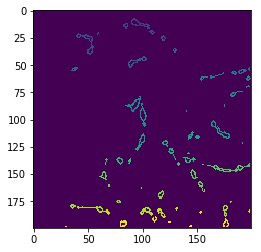

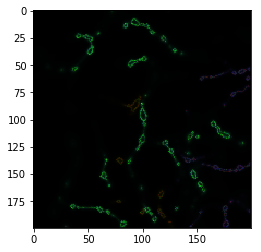

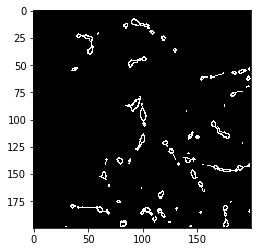

In [103]:
plt.imshow(im)
plt.show()
plt.imshow(Volume_Label_dict['y-plus']['volume'][:,:,29,:3])
plt.show()
plt.imshow(reconstruction[:,:,29],cmap='gray')
plt.show()

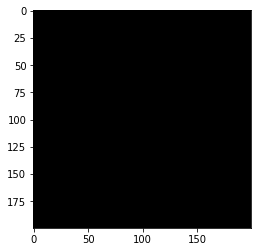

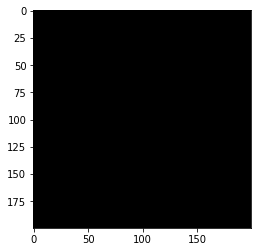

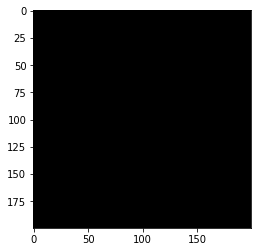

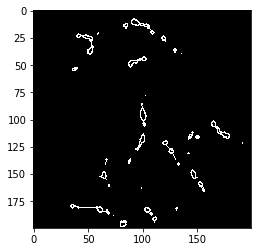

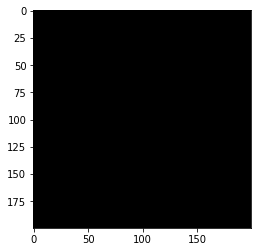

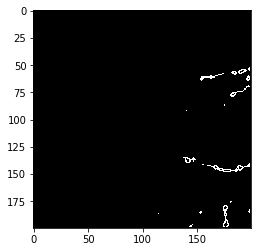

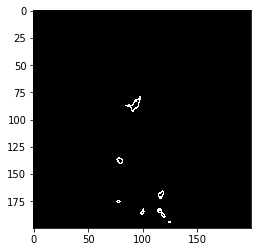

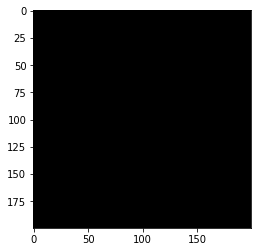

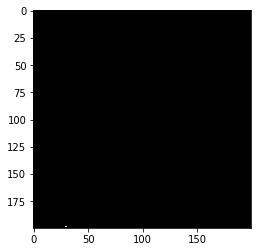

In [94]:
for i in range(9):
    plt.imshow(new_VolumeLabels[i,:,:,29],cmap='gray')
    plt.show()

In [313]:
overallRawVolume = sio.loadmat('../Sample_Datasets/Test/overallRawVolume.mat')['overallRawVolume'].astype(np.float) #shape=(200, 200, 100, 4), value range=(0,1)
volumeLabels = sio.loadmat('../Sample_Datasets/Test/volumeLabels.mat')['volumeLabels']#shape=(1, 9), each entry is an array with shape=(200, 200, 100)
new_VolumeLabels = process_volumeLabels(volumeLabels) #shape=(9,200,200,100)

In [314]:
def classes_coor(new_VolumeLabels):
    '''
    '''
    classes_coor_dict={}
    Num_Classes,L,W,H = new_VolumeLabels.shape
    for classes in range(Num_Classes):
        label_one_x, label_one_y, label_one_z = np.where(new_VolumeLabels[classes,:,:,:]==1)
        classes_coor_dict[str(classes+1)] = list(zip(label_one_x.tolist(), label_one_y.tolist(), label_one_z.tolist()))
    
    all_coor = list(product(range(L), range(W), range(H)))
    neuron_coor = []
    for values in classes_coor_dict.values():
        neuron_coor += values
        
    classes_coor_dict['0']= list(set(all_coor).difference(neuron_coor))
    
    return classes_coor_dict

In [315]:
classes_coor_dict = classes_coor(new_VolumeLabels)

In [311]:
def mixture_classes_coor(new_VolumeLabels):
    '''
    ''' 
    sum_VolumeLabel = np.sum(new_VolumeLabels, axis=0)
    x, y, z = np.where(sum_VolumeLabel>1)
    mixture_classes_coor_list = list(zip(x.tolist(), y.tolist(), z.tolist()))
    
    return mixture_classes_coor_list

In [312]:
num_classes = new_VolumeLabels.shape[0]
classes_coor_dict[str(num_classes+1)] = mixture_classes_coor(new_VolumeLabels)